In [44]:
!pip install transformers==2.1.0
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from transformers import BertTokenizer, TFBertForMaskedLM, AutoTokenizer
import tensorflow as tf
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import os
from rouge import Rouge

In [46]:
def readFile(path):
    with open(path, 'r', encoding="utf-8") as f:
        text = f.read()
    return text

def removePunct(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r" +", " ", text)
    return text


def preProcess(data):
    temp = []
    for d in data:
        text = removePunct(d)
        temp.append(text)
    return temp

def getData(text):
    x = []
    y = []
    data = text.split("\n")
    for d in data:
        try:
            x_, y_ = d.split("\t")
            x.append(x_)
            y.append(y_)
        except:
            pass
    x = preProcess(x)
    y = preProcess(y)
    return [x, y]

def removeLongSentence(data_all, n):
    x_fin = []
    for idx,ele in enumerate(data_all):
        ele_split = ele.split()
        if len(ele_split) < n and len(ele_split) > 1:
            x_fin.append(ele)            
    return x_fin

In [47]:
def mask_input(input_ids, max_len):
    inp_ids = []
    lbs = []
    idx = 0
    for inp in input_ids:
        inp = np.array(inp)
        actual_tokens = list(set(range(max_len)) - 
                            set(np.where((inp == 101) | (inp == 102) 
                                | (inp == 0))[0].tolist()))
        #We need to select 15% random tokens from the given list
        num_of_token_to_mask = int(len(actual_tokens)*0.15)
        token_to_mask = np.random.choice(np.array(actual_tokens), 
                                        size=num_of_token_to_mask, 
                                        replace=False).tolist()
        #Now we have the indices where we need to mask the tokens
        inp[token_to_mask] = 103
        inp_ids.append(inp)
        idx += 1
    inp_ids = tf.convert_to_tensor(inp_ids)
    return inp_ids

In [48]:
def prepare_input(tokenized_data):
    input_ids = [data['input_ids'] for data in tokenized_data]
    input_attention_mask = [data['special_tokens_mask'] for data in tokenized_data]
    input_attention_mask=[np.logical_not(ele).astype(int) for ele in input_attention_mask]
    # max_len = max([len(sentence) for sentence in input_ids])
    max_len = 250
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=250, padding='post', truncating='post')
    input_attention_mask = tf.keras.preprocessing.sequence.pad_sequences(input_attention_mask, maxlen=250, padding='post', truncating='post')
    input_labels = input_ids.copy()
    input_labels = tf.convert_to_tensor(input_labels)
    input_attention_mask = tf.convert_to_tensor(input_attention_mask)
    input_ids = mask_input(input_ids,max_len)
    return input_ids,input_attention_mask,input_labels

In [49]:
def plot_details(history):
    losses = history.history['loss']
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(losses)),losses)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Epoch vs Loss")
    plt.grid()
    plt.show()

In [50]:
def train_model(input_ids,input_attention_mask,input_labels):
    model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    history = model.fit([input_ids,input_attention_mask],input_labels,verbose=1,batch_size=8,epochs=10)
    plot_details(history)
    return model

In [51]:
def save_model(model,tokenizer,model_path):
  # Save the fine-tuned model
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

In [52]:
def train_transformer(dataset_path):
    train_data = readFile(dataset_path)
    _, x_train_ori = getData(train_data)
    x_train_rm = removeLongSentence(x_train_ori,200)
    # x_train_rm = x_train_rm[0:100]
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_data = [tokenizer.encode_plus(text, add_special_tokens=True, max_length=512) for text in x_train_rm]
    input_ids,input_attention_mask,input_labels = prepare_input(tokenized_data)
    model = train_model(input_ids,input_attention_mask,input_labels)
    model_path = '/content/drive/MyDrive/NLP/Hinglish_BERT'
    save_model(model,tokenizer,model_path)
    return model,tokenizer

In [53]:
def evaluate_sentence(query,model,tokenizer):
    # query = "hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke [MASK] [MASK] [MASK]"
    tokenized_data = [tokenizer.encode_plus(query, add_special_tokens=True, max_length=512)]
    input_ids,input_attention_mask,input_labels = prepare_input(tokenized_data)
    mask_loc = np.where(input_ids.numpy()[0] == 103)[0].tolist()
    out = model([input_ids,input_attention_mask])[0].numpy()
    out = out[0]
    predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()
    return tokenizer.decode(predicted_tokens)

In [54]:
def list_to_string(x_list_elements):
    fin_str = ""
    for ele in x_list_elements:
        fin_str += ele + " "
    return fin_str

def get_rouge_score(model,last_n_words,x_sentences,tokenizer):
    rouge_scores = []
    rouge = Rouge()
    for idx,ele in enumerate(x_sentences):
        ele_fin = ele.split()[:-last_n_words]
        ele_fin += ['MASK'] * last_n_words
        ele_short_sent_mask = list_to_string(ele_fin)
        ele_true_token = ele.split()[-last_n_words:]
        ele_true_sent = list_to_string(ele_true_token)
        pred_sent = evaluate_sentence(ele_short_sent_mask,model,tokenizer)
        if len(pred_sent.split())>0:
            scores = rouge.get_scores(pred_sent, ele_true_sent, avg=True)
            # print("PRED: ",pred_sent,"  TRUE: ",ele_true_sent,scores['rouge-l'])
            rouge_scores.append(scores['rouge-l']['f'])
    return rouge_scores

def get_all_rouge_scores(model,x_sentences,tokenizer):
    last_n_words = [3,4,5]
    all_rouge_scores = []
    for ele in last_n_words:
        r_scores = get_rouge_score(model,ele,x_sentences,tokenizer)
        all_rouge_scores.append(np.mean(r_scores))
        print("Rouge Scores done for last ", ele , " words")
    return all_rouge_scores, last_n_words

def plot_rouge_scores(all_rouge_scores_mean,last_n_words):
    plt.xlabel("Predicted Words")
    plt.ylabel("Rouge Scores")
    plt.title("Predicted Words vs Rouge Scores")
    # plot lines
    last_n_words = [format(x, 'd') for x in last_n_words]
    plt.bar(last_n_words, all_rouge_scores_mean,color ='b',width = 0.4)
    plt.show()

In [55]:
def test_transformer(dataset_path, model, tokenizer):
    test_data = readFile(dataset_path)
    _, x_test_ori = getData(test_data)
    x_test_rm = removeLongSentence(x_test_ori,200)
    all_rouge_scores, last_n_words = get_all_rouge_scores(model,x_test_rm,tokenizer)
    plot_rouge_scores(all_rouge_scores, last_n_words)


Epoch 1/10


936/936 [==============================] - 529s 514ms/step - loss: 0.1843
Epoch 2/10
936/936 [==============================] - 479s 512ms/step - loss: 0.0356
Epoch 3/10
936/936 [==============================] - 479s 512ms/step - loss: 0.2380
Epoch 4/10
936/936 [==============================] - 477s 510ms/step - loss: 0.8036
Epoch 5/10
936/936 [==============================] - 477s 510ms/step - loss: 0.7994
Epoch 6/10
936/936 [==============================] - 478s 510ms/step - loss: 0.7967
Epoch 7/10
936/936 [==============================] - 479s 511ms/step - loss: 0.7975
Epoch 8/10
936/936 [==============================] - 478s 511ms/step - loss: 0.8256
Epoch 9/10
936/936 [==============================] - 477s 510ms/step - loss: 0.8211
Epoch 10/10
936/936 [==============================] - 478s 511ms/step - loss: 0.8157


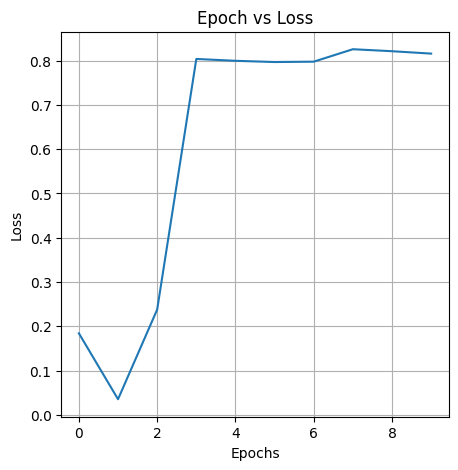

In [56]:
model,tokenizer = train_transformer('/content/train.txt')

In [ ]:
test_transformer('/content/dev.txt',model,tokenizer)

In [23]:
test_data = readFile('/content/dev.txt')
_, x_test_ori = getData(test_data)
x_test_rm = removeLongSentence(x_test_ori,200)

In [ ]:
def load_model(model_path):
    model = TFBertForMaskedLM.from_pretrained(model_path,from_pt=True)
    tokenizer = BertTokenizer.from_pretrained(model_path,from_pt=True)
    return model

In [ ]:
query = "hello yar mein is [MASK] ko nahi  [MASK] hoon tho tho mein thode der ke liye"
predicted_ans = evaluate_sentence(query,model,tokenizer)

In [ ]:
predicted_ans

'movie haion li'

In [ ]:
pred_vals = predicted_ans.split()

In [ ]:
pred_vals

['movie', 'haion', 'li']

In [ ]:
tokens = query.split()

# Replace each instance of [MASK] with the corresponding value
for i, token in enumerate(tokens):
    if token == "[MASK]":
        tokens[i] = pred_vals.pop(0)

# Join the tokens back into a string
result = " ".join(tokens)

In [ ]:
actual_sentence = "hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye"

In [ ]:
print("\nInput sentence with Mask: ",query,"\n")
print("\nActual Sentence: ",actual_sentence,"\n")
print("\nPredicted Sentence: ",result,"\n")


Input sentence with Mask:  hello yar mein is [MASK] ko nahi  [MASK] hoon tho tho mein thode der ke liye 


Actual Sentence:  hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye 


Predicted Sentence:  hello yar mein is movie ko nahi haion hoon tho tho mein thode der ke liye 



In [ ]:
if __name__ == "__main__":
  # To train the model give dataset path and uncomment the train_transformer method
    # dataset_path = '/content/train.txt'
    # model,tokenizer = train_transformer(dataset_path)

  # To use the transformer as Masked Language Model
    model_path = '/content'
    model,tokenizer = load_model(model_path)
    query = input("Input the phrase along with [MASK] to predict [MASK] values")
    # query = "hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke [MASK] [MASK]"
    predicted_ans = evaluate_sentence(query,model,tokenizer)
    print(query)